# Table of Contents
 <p><div class="lev1"><a href="#Problem-Statement"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement</a></div><div class="lev1"><a href="#Data-understanding"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data understanding</a></div><div class="lev2"><a href="#Read-in-the-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read-in the data</a></div><div class="lev2"><a href="#Clean-up"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clean-up</a></div><div class="lev2"><a href="#Train-test-split"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train-test split</a></div><div class="lev1"><a href="#Data-Processing-Pipelines"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Processing Pipelines</a></div><div class="lev2"><a href="#Log-transform-interactions"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Log-transform <code>interactions</code></a></div><div class="lev2"><a href="#Categorical-Encoding"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Categorical Encoding</a></div><div class="lev3"><a href="#Option-1---Target-coding"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Option 1 - Target coding</a></div><div class="lev3"><a href="#Option-2---One-hot-encoding"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Option 2 - One hot encoding</a></div><div class="lev2"><a href="#Re-balancing-sale"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Re-balancing <code>sale</code></a></div><div class="lev3"><a href="#Random-undersampler"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Random undersampler</a></div><div class="lev1"><a href="#Modelling"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></div><div class="lev2"><a href="#Baseline-Models"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baseline Models</a></div><div class="lev3"><a href="#Statsmodels-Logistics-Regression"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Statsmodels Logistics Regression</a></div><div class="lev3"><a href="#Logistics-Regression"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Logistics Regression</a></div><div class="lev3"><a href="#Random-Forest-Classifier"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Random Forest Classifier</a></div><div class="lev2"><a href="#Comparison-of-Baseline-Models"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Comparison of Baseline Models</a></div><div class="lev2"><a href="#Challenger-Model"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Challenger Model</a></div><div class="lev3"><a href="#Gradient-Boosting"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Gradient Boosting</a></div><div class="lev3"><a href="#Neural-Network"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Neural Network</a></div><div class="lev2"><a href="#Comparison-Baseline-Models-<->-Challengers"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Comparison Baseline Models &lt;-&gt; Challengers</a></div><div class="lev1"><a href="#Summary"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></div>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import catboost
import shap
import seaborn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import tensorflow as tf
import category_encoders

from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import OrdinalEncoder
from pandas_profiling import ProfileReport

from IPython.display import display, Markdown

# Problem Statement

Work with the attached dataset to identify users who are more likely to do a sale.

It's important for the business to understand **what makes someone more likely to buy** an insurance.
For this purpose, we assembled a dataset with features of users and their sessions and an indicator if they resulted in a sale or not.

Your goal is to work with this dataset and **identify users who are more likely to convert** so that we can personalise the experience for them.

We don't expect a perfect solution (actually, we believe there isn't one). But please take several hours to implement a well structured approach in a Jupyter notebook.

Afterwards, we'll discuss your solution in detail. Be ready to answer question like, why did you choose this approach and not others, how will you measure the performance of your solution and how do you interpret the final results


--------

# Data understanding

| field name   	| description                                                  	|
|--------------	|--------------------------------------------------------------	|
| id           	| unique identifier of the rows                                	|
| date         	| date of the session                                          	|
| campaign_id  	| id of the advertising campaign that led the user to the site 	|
| group_id     	| id of the group that lead the user to the site               	|
| age_group    	| age range of the user                                        	|
| gender       	| gender of the user                                           	|
| user_type    	| internal id of the type of user                              	|
| platform     	| device type of the user                                      	|
| state_id     	| US state id of the user location                             	|
| interactions 	| number of interactions of the user                           	|
| sale         	| boolean indicator if the user has made a sale or not         	|

## Read-in the data

In [2]:
sales_data = pd.read_csv('sales_data.csv.gz',
                          compression='gzip',
                          sep=',',
                          header=0,
                          index_col=0)

In [3]:
sales_data

date  campaign_id  group_id age_group gender  user_type  \
id                                                                      
277133  2021-05-04            3       372     45-49      F          0   
270342  2021-05-04            3       313     35-39      F          4   
161280  2021-05-02            3       321     30-34      M          1   
252773  2021-05-04            3       426     30-34      F          0   
118886  2021-05-01            3       337     40-44      M          8   
...            ...          ...       ...       ...    ...        ...   
71168   2021-05-01            3       404     30-34      F          2   
8348    2021-05-01            3       329     35-39      F          2   
242565  2021-05-04            3       361     35-39      F          7   
199292  2021-05-03            3       377     40-44      M          7   
106848  2021-05-01            3       488     35-39    NaN          4   

       platform  state_id  interactions  sale  
id                                             
277133  desktop        19          5249   0.0  
270342  desktop        16          1522   0.0  
161280  desktop        25             2   0.0  
252773      NaN        27             2   1.0  
118886  desktop        16             2   0.0  
...         ...       ...           ...   ...  
71168       NaN         5             2   0.0  
8348    desktop        26          1625   0.0  
242565  desktop        12             2   0.0  
199292  desktop        20          1259   0.0  
106848      NaN        28             2   0.0  

[426324 rows x 10 columns]

**Let's use `pandas_profiling` for a quick and exhaustive summary of all features and their interactions**

In [4]:
profile = ProfileReport(sales_data, title="Sales Data Report", explorative=True,
                        dark_mode=True)

In [5]:
# profile.to_widgets()

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Below are some observations extracted from `pandas_profiling`**:

  1. There are 28 missing values in the target `sale`. We will safely remove
     those from the dataset, prior to any further analysis
     
   
     
  2. Huge imbalance in the target `sale` - 93.6% of all observations have **not**
     resulted in a sale. 
     This imbalance must be addressed before model training and will determine
     the performance metric we chose.
     
  
  3. There is considerable imbalance in the feature `platform` - approximately 63% of users 
     come from a desktop machine, 36% have missing values and less than 1% come from
     mobile devices.
     Depending on whether the missing values represent merely a data quality
     issue or an actual meaningful signal about user behaviour (e.e. user redirected
     through third parties have "undetected" platform), we can either impute
     the missing values or model them as a separate entity.
     In this submission I have chosen the latter.
   
   
  4. All features, except `interactions` are categorical.
     We will have to encode them to be able to use most machine learning methods.
     In this submission I have tried two methods - one-hot encoding and leave-one-out target coding.
     They both perform similarly, so I leave the latter in the main code.
   
  
  5. The feature `interactions` is heavily skewed. 
     We will log-transform it to make it more Gaussian-like and hence reduce the likelihood
     that its heavy tails bias our models.
     
     
  6. The features `group_id` and `user_type` have high cardinalities. If categorical features are one-hot encoded
     this will be a problem, as this will induce a lot of spareness in the encoded dataset.
     Furthermore, features with many categories will bias most learning algorithms in their favour.
     I have tried one-hot encoding as part of this submission and it only works at the level of the
     target-coding if the high cardinality features are compacted (e.g. by creating a new category "Other")
     
     
  7. The *Phi_K* correlation plot suggests correlation between `sales` and the features `age_group`,
     `gender` and `state_id`. 
     Despite being only visual this observation is a first indication of what features might be
     influential in this problem and should be verified.
     
     
  8. The `date`feature has only 9 distinct values and doesn't provide enough information for
     time series analysis. We will thus drop it.

## Clean-up

**Let's remove the observation with missing target `sale`**

In [7]:
empty_sales_mask = np.isnan(sales_data['sale'])

sales_data_cleaned = sales_data[~empty_sales_mask].copy()

In [8]:
sales_data_cleaned

date  campaign_id  group_id age_group gender  user_type  \
id                                                                      
277133  2021-05-04            3       372     45-49      F          0   
270342  2021-05-04            3       313     35-39      F          4   
161280  2021-05-02            3       321     30-34      M          1   
252773  2021-05-04            3       426     30-34      F          0   
118886  2021-05-01            3       337     40-44      M          8   
...            ...          ...       ...       ...    ...        ...   
71168   2021-05-01            3       404     30-34      F          2   
8348    2021-05-01            3       329     35-39      F          2   
242565  2021-05-04            3       361     35-39      F          7   
199292  2021-05-03            3       377     40-44      M          7   
106848  2021-05-01            3       488     35-39    NaN          4   

       platform  state_id  interactions  sale  
id                                             
277133  desktop        19          5249   0.0  
270342  desktop        16          1522   0.0  
161280  desktop        25             2   0.0  
252773      NaN        27             2   1.0  
118886  desktop        16             2   0.0  
...         ...       ...           ...   ...  
71168       NaN         5             2   0.0  
8348    desktop        26          1625   0.0  
242565  desktop        12             2   0.0  
199292  desktop        20          1259   0.0  
106848      NaN        28             2   0.0  

[426296 rows x 10 columns]

**As mentioned before we will keep the mising values as a special category
to be explicitly modelled**.

This affects mostly the `platform` feature, since it has the highest
fraction of missing values.

In [9]:
sales_data_cleaned = sales_data_cleaned.fillna('not available')

And finally removing `date`

In [10]:
sales_data_cleaned = sales_data_cleaned.drop(columns='date')

## Train-test split

Before we continue we'll allocate a *test* set to be used as a proxy for *unseen* data. 
That would be the final dataset on which models will be compared at the end.

Importantly this must be done before any encoding or rebalancing.
We want to keep the data imbalance in the test set and check model performance on it.
In this way we'll know if our model has learned useful information to detect
the positive signal resulting in a sale.

Any rebalancing or encoding will be learned from the training dataset to ensure 
no data leakage.

To generate the split and keep the data imbalance, we use `StratifiedShuffleSplit`
and take 20% of the data as test.



In [11]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

all_but_target = sales_data_cleaned.columns != 'sale'
X = sales_data_cleaned.loc[:, all_but_target]
y = sales_data_cleaned[['sale']]


for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

In [12]:
y.groupby(by='sale').size()

sale
0.0    398800
1.0     27496
dtype: int64

In [13]:
y_train.groupby(by='sale').size()

sale
0.0    319039
1.0     21997
dtype: int64

In [14]:
y_test.groupby(by='sale').size()

sale
0.0    79761
1.0     5499
dtype: int64

As we can see the imbalance in `sale` is very similar across the original
dataset, the training dataset and the test dataset.

# Data Processing Pipelines

As a last step before modelling, we'll create the encoding and 
rebalancing logic.

There are many options to encode categorical variables with the 
most popular one being **one-hot encoding**.
Its alternative name, *dummy coding*, suggests that it may not be
the obvious choice for all problems.
Nevertheless I tried it and it offers very similar performance if
the high cardinality features are compacted. 

Another category of encoding methods is known as **target coding**, 
where the main idea is that information about the target (e.g. mean value)
conditional on the individual categories is used to encode them.
The encoding is typically futher combined with the so-called *prior*, which
represents a global statistic unconditioned on any category.

There are several target-coding methods implemented in the Python package
`category_encoders`.

I have tried `TargetEncoder` and `LeaveOneOutEncoder`, both with similar performance.


In [15]:
X_train

campaign_id  group_id age_group gender  user_type       platform  \
id                                                                         
148921            3       380     35-39      F          5        desktop   
421695            3       438     35-39      F          1  not available   
404077            3       402     35-39      M          2  not available   
49202             3       349     40-44      M          7        desktop   
348599            3       433     45-49      F          5  not available   
...             ...       ...       ...    ...        ...            ...   
410359            3       426     45-49      F          2  not available   
403996            3       228     35-39      M          1        desktop   
74562             3       395     30-34      M          8        desktop   
24125             3       300     30-34      F          2        desktop   
421324            3       351     40-44      M          7        desktop   

        state_id  interactions  
id                              
148921        22           230  
421695        12             2  
404077        28           820  
49202         50           139  
348599        15          1706  
...          ...           ...  
410359        10             2  
403996         2             2  
74562          7          1173  
24125         32             2  
421324        20             2  

[341036 rows x 8 columns]

In [16]:
# We need to keep these around for convenience later on
feature_cols = ['campaign_id', 'group_id', 'age_group', 'gender', 'user_type', 'platform', 'state_id', 'interactions']
cat_cols = ['campaign_id', 'group_id', 'age_group', 'gender', 'user_type', 'platform', 'state_id']
target_col = ['sale']

Before, we continue let's define a function to log-transform the `interactions`
feature.
It will be used in the final `sklearn.pipeline.Pipeline`

## Log-transform `interactions`

In [17]:
def log_trans(df):
    df['interactions'] = np.log10(df['interactions'])
    return pd.DataFrame(df, columns=df.columns)


## Categorical Encoding

### Option 1 - Target coding

In [18]:
# both do very similary

leave_one_out_enc = \
    category_encoders.leave_one_out.LeaveOneOutEncoder(cols=cat_cols,
                                                       random_state=42,
                                                       sigma=0.05)

target_encoder = \
    category_encoders.target_encoder.TargetEncoder(cols=cat_cols,                                                                
                                                   min_samples_leaf=500,
                                                   smoothing=1)

### Option 2 - One hot encoding

In [19]:
for col in cat_cols:
    # all, but the last one 'interactions'
    X_train[col] = X_train[col].astype('str')
    X_test[col] = X_test[col].astype('str')

In [20]:
campaign_id_cats = list(X_train['campaign_id'].value_counts().index)
group_id_cats = list(X_train['group_id'].value_counts().index)
age_group_cats = list(X_train['age_group'].value_counts().index)
gender_cats = list(X_train['gender'].value_counts().index)
user_type_cats = list(X_train['user_type'].value_counts().index)
platform_cats = list(X_train['platform'].value_counts().index)
state_id_cats = list(X_train['state_id'].value_counts().index)

In [21]:
def reduce_column(df, column, q):  
    
    column_freqs = pd.DataFrame(df[column].value_counts())
    column_freqs = column_freqs.reset_index().rename(columns={'index': column,
                                                               column: 'count'})
    
    
    quantile = np.int(np.floor(np.quantile(column_freqs['count'], q=q/100)))
    threshold_mask = column_freqs['count'] > quantile
    
    
    df[column] = np.where(df[column].isin(column_freqs[~threshold_mask][column]),
                          'Other', df[column])
    
    return pd.DataFrame(df, columns=df.columns)

In [86]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories=[campaign_id_cats,
                                group_id_cats,
                                age_group_cats,
                                gender_cats,
                                user_type_cats,
                                platform_cats,
                                state_id_cats],
                    drop='first', sparse=False)

encoder = ColumnTransformer([('cat', enc, cat_cols)],
                              remainder='passthrough')



ohe_pipe = Pipeline([("reduce_group_id",
                      FunctionTransformer(reduce_column,
                                         kw_args={'q': 99,
                                        'column': 'group_id'})),
         
                     ("one_hot_encoding", encoder)])

**And finally define the encoding pipeline**

In [89]:
# both target-coding methods do very similary in terms of mode performance
encoding_pipeline = Pipeline([
    ("log_trans_interactions", FunctionTransformer(log_trans)), # always active
    # ("target_encoder", target_encoder),  # replaceable by leave_one_out_enc
    ('leave_one_out_enc', leave_one_out_enc), # replaceable by target_encoder
    ])
    


We now learn the encoding from our training dataset and use it to
transform the test dataset.

In [91]:
X_train_processed = encoding_pipeline.fit_transform(X_train.copy(), y_train)

# importantly, only transform X_test, don't fit it
X_test_processed = encoding_pipeline.transform(X_test.copy())

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


**This is how our encoded training dataset looks like:**

In [92]:
X_train_processed

campaign_id  group_id  age_group    gender  user_type  platform  \
id                                                                        
148921     0.064972  0.058964   0.058979  0.076748   0.058101  0.064608   
421695     0.062959  0.057963   0.053258  0.084822   0.061982  0.065355   
404077     0.065451  0.063377   0.055670  0.044467   0.070165  0.063153   
49202      0.068225  0.060133   0.081790  0.052788   0.065206  0.063335   
348599     0.062655  0.071872   0.089473  0.078551   0.068743  0.066866   
...             ...       ...        ...       ...        ...       ...   
410359     0.060622  0.067146   0.091456  0.077340   0.061130  0.064453   
403996     0.065305  0.053810   0.053451  0.048431   0.061702  0.064885   
74562      0.060387  0.060852   0.040525  0.052182   0.066841  0.067272   
24125      0.060083  0.067476   0.042396  0.072862   0.063898  0.064774   
421324     0.060514  0.059713   0.070726  0.048991   0.063168  0.065999   

        state_id  interactions  
id                              
148921  0.066816      2.361728  
421695  0.059073      0.301030  
404077  0.077831      2.913814  
49202   0.055190      2.143015  
348599  0.032520      3.231979  
...          ...           ...  
410359  0.056765      0.301030  
403996  0.060694      0.301030  
74562   0.047185      3.069298  
24125   0.051436      0.301030  
421324  0.063608      0.301030  

[341036 rows x 8 columns]

**This is how our encoded test dataset looks like:**

In [93]:
X_test_processed

campaign_id  group_id  age_group    gender  user_type  platform  \
id                                                                        
137980     0.063397  0.075871   0.050993  0.076757   0.066394  0.062852   
268057     0.063397  0.071778   0.050993  0.076757   0.065721  0.065366   
97548      0.063397  0.069227   0.088960  0.076757   0.062918  0.062852   
412151     0.063397  0.074661   0.040761  0.050327   0.062448  0.065366   
164008     0.063397  0.064941   0.080211  0.050327   0.062448  0.065366   
...             ...       ...        ...       ...        ...       ...   
137183     0.063397  0.060465   0.050993  0.050327   0.064885  0.062852   
291801     0.093611  0.117647   0.040761  0.076757   0.064885  0.069317   
303190     0.063397  0.062682   0.050993  0.050327   0.065721  0.062852   
122097     0.093611  0.061404   0.080211  0.076757   0.064690  0.065366   
424970     0.063397  0.060396   0.080211  0.076757   0.064885  0.062852   

        state_id  interactions  
id                              
137980  0.052820      3.821251  
268057  0.055466      0.301030  
97548   0.058394      3.533136  
412151  0.035693      4.291458  
164008  0.052979      3.745465  
...          ...           ...  
137183  0.049427      0.301030  
291801  0.052979      0.301030  
303190  0.058394      3.034227  
122097  0.060691      0.301030  
424970  0.072389      0.301030  

[85260 rows x 8 columns]

## Re-balancing `sale`

Rebalancig the `sale` feature is very important during training, if
we don't want our models to simply learn to predict the majority class.

While choosing a scoring metric appropriate for imbalanced datasets is
certainly important, that alone is often not enough.

For this reason, in addition to choosing an appropriate metric, we will rebalance 
the target

Because there're plenty of samples, I have opted for a downsampling strategy of
the majority class (no sale).
By reducing the size of the dataset all further analysis downstream
(including modelling) will be sped up, which in the context of this submission
was an important factor.

There are many ways to down- or under-sample a majority class. 
By far a popular first choice is the random under-sampler, which, as the name
suggests, randomly selects majority samples until a desired proportion
of majority and minority samples is achieved.

The random under-sampler is extremely fast and suitable for mixed data.
Caution must be taken to sample sufficiently from the distribution of the
majority class, so that its properties are preserved in the undersampled dataset.

I have also tried other popular methods from `imblearn`, which had similar
results and the cost of processing time.

For this reason, the random under-sampler is provided in the main code.

In [94]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

### Random undersampler

In [95]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=1, replacement=False)
tomek = TomekLinks(sampling_strategy='all', n_jobs=-1)
nearmiss = NearMiss(sampling_strategy=1, version=1, n_jobs=-1, n_neighbors=3)

X_train_processed_resampled, y_train_processed_resampled = rus.fit_resample(X=X_train_processed, y=y_train)
sample_indeces = rus.sample_indices_

"""Uncomment some of these below, if you want to try alternative undersamplers""";

# X_train_processed_resampled, y_train_processed_resampled = tomek.fit_resample(X=X_train_processed, y=y_train)
# sample_indeces = tomek.sample_indices_

# X_train_processed_resampled, y_train_processed_resampled = nearmiss.fit_resample(X=X_train_processed, y=y_train)
# sample_indeces = nearmiss.sample_indices_


And this is the rebalanced training data

In [96]:
X_train_processed_resampled

campaign_id  group_id  age_group    gender  user_type  platform  \
0         0.063131  0.067561   0.089640  0.051975   0.066639  0.070138   
1         0.062972  0.064806   0.081564  0.050470   0.064988  0.065714   
2         0.060136  0.057024   0.037093  0.046639   0.072868  0.067875   
3         0.060811  0.070793   0.049056  0.081000   0.071178  0.067022   
4         0.063654  0.061823   0.079296  0.075416   0.069616  0.060174   
...            ...       ...        ...       ...        ...       ...   
43989     0.060076  0.057429   0.041666  0.076181   0.066933  0.064027   
43990     0.063514  0.081057   0.096937  0.073002   0.066066  0.066857   
43991     0.069869  0.067323   0.093553  0.075415   0.064779  0.062597   
43992     0.060202  0.061539   0.050127  0.054611   0.061012  0.058063   
43993     0.063960  0.057594   0.055589  0.051271   0.065744  0.061800   

       state_id  interactions  
0      0.055140      3.147058  
1      0.053772      0.301030  
2      0.056041      0.301030  
3      0.058759      3.332438  
4      0.057421      0.301030  
...         ...           ...  
43989  0.070167      0.301030  
43990  0.138660      3.925157  
43991  0.052129      3.189771  
43992  0.135085      3.628593  
43993  0.133364      3.729489  

[43994 rows x 8 columns]

corresponding to the original:

In [97]:
X_train.iloc[sample_indeces]

campaign_id group_id age_group gender user_type       platform  \
id                                                                      
167697           3      347     45-49      M         0        desktop   
91754            3      414     45-49      M         2  not available   
157719           3      352     30-34      M         8        desktop   
63640            3      290     35-39      F         4        desktop   
104954           3      466     45-49      F         2  not available   
...            ...      ...       ...    ...       ...            ...   
308051           3      404     30-34      F         3  not available   
286593           3      311     45-49      F         0        desktop   
367150           3      403     45-49      F         8  not available   
204248           3      414     35-39      M         2  not available   
89914            3      392     35-39      M         0        desktop   

       state_id  interactions  
id                             
167697       10          1403  
91754        10             2  
157719       10             2  
63640        10          2150  
104954       10             2  
...         ...           ...  
308051       28             2  
286593       27          8417  
367150       16          1548  
204248       27          4252  
89914        27          5364  

[43994 rows x 8 columns]

In [98]:
t = y_train_processed_resampled.groupby(by='sale').size()
t2 = y_train.groupby(by='sale').size()
t3 = y_test.groupby(by='sale').size()

ratio_positives = t[1] / (t[0] + t[1])
ratio_positives_orig = t2[1] / (t2[0] + t2[1])
ratio_positives_test = t3[1] / (t3[0] + t3[1])

display(Markdown(f"**Ratio of positive targets in original training data is: {ratio_positives_orig}**"))
display(Markdown(f"**Ratio of positive targets in test data is: {ratio_positives_test}**"))
display(Markdown(f"**Ratio of positive targets in rebalanced training data is: {ratio_positives}**"))

**Ratio of positive targets in original training data is: 0.06450052193903283**

**Ratio of positive targets in test data is: 0.06449683321604503**

**Ratio of positive targets in rebalanced training data is: 0.5**

As we see the rebalanced training data has an equal proportion of
minority and majority samples

------

# Modelling

Before we begin modelling, we need to define the performance metric to optimize.

The **f1 score** and **balanced accuracy** are suitable metrics for imbalanced datasets.
Even though we rebalanced our training data, we still want to be sensitive
to a classifier making trivial predictions on the (imbalanced) test data.

For this reason the f1 score will be used as a performance metric with
the added convenience that to compute it we will require the *precision*
and *recall* of our classifiers. 

These are important indicators, specifically when a tradeoff between false positives
and true negatives is an integral part of the business question, as it is here.


Essentially low precision, but high recall, will allows us to identify interested
customers well, at the expense of maybe bothering uninterested customers.
In this situation we might even tolerate lower precision, because in a real
applicatin the list of potential customers generated by our model will
typically be curated to avoid contacting the same person too often.
Hence falsely reaching out to an uninterested buyer may be acceptable from a business 
perspective.


And vice versa, high precision and low recall will ensure that we only spend effort in
contacting "sure" sales, at the expense of possibly omitting others with buying inclinations.

----

As a first point, let's calculate the expected f1 score of a dummy classifier that
always predicts the minority class on the test set (i.e. recall is 1).
Such a classifier does not learn from the training data at all.

This will serve as our lowest possible benchmark.
If a model performs worse than that, we will know there've been serious
issues during training.


In [99]:
dummy_clf_f1 = 2*ratio_positives_test / (ratio_positives_test + 1)

display(Markdown("**Expected F1 Score of a dummy classifier predicting "
                 f"always positive is: {dummy_clf_f1}**"))

**Expected F1 Score of a dummy classifier predicting always positive is: 0.12117806498529071**

## Baseline Models

In addition to the dummy baseline, we'll define two more classical machine
learning models to serve as proper baselines. These are **logistics regression**
and **random forest classifier**.

Both serve as a good first choice due to their efficiency, simplicity and
interpretability.

The logistics regression will be implemented in two different ways, 
one with the `statsmodels` package and the other with `sklearn.linear_model`.
The `statsmodels` implementation allows for a more convenient specification
of the categorical variables (via the `patsy` package), while the `sklearn`
implementation requires categorical encoding.
We will use the raw *unencoded* training data for the former and
the encoded training data for the latter. 

Since by default `statsmodels` uses one-hot-encoding we will. thus easily
compare that encoding scheme with our target-coding.

### Statsmodels Logistics Regression

In [100]:
# use the sample_indeces from our RandomUndersampler

sm_train_data = X_train.iloc[sample_indeces].join(y_train.iloc[sample_indeces])
sm_test_data = X_test.join(y_test)


"""
Uncomment below if target-coding is desired (**)
""";

# sm_train_data = X_train_processed_resampled.join(y_train_processed_resampled)
# sm_test_data = X_test_processed.join(y_test)



Since statmodels will use one-hot-encoding by defauls we need to pay attention
to the high cardinality features, `group_id` and `user_type``.
These will bias the model toward them and also induce a lot of sparsness in the dataset.

Experiments showed that sparseness is an issue, since the MLE estimation fails to converge.

Hence, these will be dropped from the `statsmodels` implementation.

In [101]:
# we drop the high cardinality group_id and user_type features
formula = ('sale ~ C(campaign_id, Treatment(reference="3")) + '
           #'C(group_id) + '
           'C(age_group, Treatment(reference="30-34")) + '
           'C(gender, Treatment(reference="F")) + '
           # 'C(user_type) +'
           'C(platform) + '
           'C(state_id) + '
           'interactions')


"""
Uncomment below if target-coding is desired (**)
""";

# formula = ('sale ~ campaign_id + '
#            'group_id + '
#            'age_group + '
#            'gender + '
#            'user_type +'
#            'platform  + '
#            'state_id + '
#            'interactions')


log_reg_sm = smf.logit(formula=formula, data=sm_train_data).fit()

Optimization terminated successfully.
         Current function value: 0.653719
         Iterations 5


The logistics regression essentially models the logarithm of the odds raio
as a linear function of the independent variables. This means that the
coefficients tell us how many units of change one unit of change in the
independent variables cause in the dependent variable (log ods ratio).

It's often, however, easier to work with the odds ratio and not with 
its logarithm. 
Hence, below we exponentiate the coefficients to obtain the
effects of each feature on the odds ratio, that is the ratio
of probability of sale over the probability of no sale.


In [102]:
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg_sm.params,
        "Lower CI": log_reg_sm.conf_int()[0],
        "Upper CI": log_reg_sm.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios["p-values"] = log_reg_sm.pvalues

In [103]:
# uncomment for full summary

# log_reg_sm.summary()

Let's see only the odds ratios corresponding to categories with considerable
statistical significance


In [104]:
odds_ratios[odds_ratios['p-values'] < 0.01]

OR  Lower CI  \
Intercept                                           0.462120  0.343505   
C(campaign_id, Treatment(reference="3"))[T.2]       1.493511  1.347583   
C(age_group, Treatment(reference="30-34"))[T.35...  1.315446  1.237273   
C(age_group, Treatment(reference="30-34"))[T.40...  2.372429  2.232821   
C(age_group, Treatment(reference="30-34"))[T.45...  2.518744  2.389119   
C(gender, Treatment(reference="F"))[T.M]            0.698323  0.669114   
C(state_id)[T.14]                                   2.328141  1.623605   
C(state_id)[T.19]                                   2.041204  1.492378   
C(state_id)[T.20]                                   1.925581  1.408468   
C(state_id)[T.22]                                   1.932965  1.396582   
C(state_id)[T.24]                                   3.687529  2.625288   
C(state_id)[T.25]                                   3.312890  2.423081   
C(state_id)[T.27]                                   3.008124  2.229272   
C(state_id)[T.28]                                   2.169541  1.598663   

                                                    Upper CI       p-values  
Intercept                                           0.621693   3.385482e-07  
C(campaign_id, Treatment(reference="3"))[T.2]       1.655242   2.063944e-14  
C(age_group, Treatment(reference="30-34"))[T.35...  1.398559   1.768920e-18  
C(age_group, Treatment(reference="30-34"))[T.40...  2.520767  1.574143e-171  
C(age_group, Treatment(reference="30-34"))[T.45...  2.655401  2.400744e-257  
C(gender, Treatment(reference="F"))[T.M]            0.728808   5.940879e-61  
C(state_id)[T.14]                                   3.338399   4.317670e-06  
C(state_id)[T.19]                                   2.791862   7.981433e-06  
C(state_id)[T.20]                                   2.632548   4.016000e-05  
C(state_id)[T.22]                                   2.675357   7.061622e-05  
C(state_id)[T.24]                                   5.179573   5.162805e-14  
C(state_id)[T.25]                                   4.529457   6.103484e-14  
C(state_id)[T.27]                                   4.059087   5.858058e-13  
C(state_id)[T.28]                                   2.944278   6.645274e-07

**Already here we see some interesting insights**:


  1. Four features appear to be most prominent - `campain_id`, `age_group`, `gender` and `state_id`.
     Incidently, three of those we have already hypothesized to be correlated with the
     target in our visual inspection with `pandas_profiling`
     

  2. The odds ratios increase monotonously with age. The probability of sale is 2.52 times higher
     among customers in the 45-49 age group, compared to the treatment 30-34 age
     group. Likewise for the other age groups. 
     This is reasonable, as it could be argued that younger people are less interested
     in buying insurance than older ones
     
     
  3. Males have 0.7 times **less** probability than females of buying insurace.
     That is interesting, but without more context, it's hard to reality check it. 
     However, it may be related to aggresiveness and risk aversion
     
     
  4. Certain state_ids, namely 24, 25 and 27 almost triple the probability of a sale.
     That's quite interesting and deservers further investigations with more context.

### Logistics Regression

This is the standard implementation with some hyper-parameter tuning.

In [105]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(penalty='l2',
                                 random_state=42,
                                 class_weight='balanced',
                                 max_iter=300, n_jobs=-1)

lr_pipe = Pipeline([("lr_classifier", clf_log_reg)])



parameters = {'lr_classifier__C': [0.05, 0.1, 0.5, 1],
              'lr_classifier__tol': [0.0001, 0.001]}

clf_grid_search = GridSearchCV(lr_pipe,
                               param_grid=parameters,
                               scoring='f1',
                               refit=True,
                               cv=5,
                               n_jobs=-1,
                               verbose=0)

In [106]:
clf_grid_search.fit(X_train_processed_resampled,
                    y_train_processed_resampled['sale']);

In [107]:
best_estimator_lr = clf_grid_search.best_estimator_

### Random Forest Classifier

The final baseline model is the random forest classifier.
It's fast and resilient to overfitting due to its usage of bootstrap
samples. 
For this reason, we're not explicitly using cross-validation.

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
clf_rf = RandomForestClassifier(n_estimators=100, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=42)
rf_pipe = Pipeline([("rf_classifier", clf_rf)])

In [110]:
rf_pipe.fit(X_train_processed_resampled, y_train_processed_resampled['sale']);

## Comparison of Baseline Models

In this section we'll compare the performance of our baselines on the **test data**
and try to figure out what they have learnt from the data.

The comparison will be done along three main directions:

   1. **Feature importances**
   2. **F1 Score**
   3. **RoC and Precision-Recall curves**

In [111]:
pos_label_index_lr = np.where(best_estimator_lr['lr_classifier'].classes_ == 1)[0]
pos_label_index_rf = np.where(rf_pipe['rf_classifier'].classes_ == 1)[0]

In [112]:
# these are the raw probability scores on the test data
y_pred_lr = best_estimator_lr.predict_proba(X_test_processed)[:,pos_label_index_lr].squeeze()
y_pred_rf = rf_pipe.predict_proba(X_test_processed)[:,pos_label_index_rf].squeeze()
y_pred_sm = log_reg_sm.predict(sm_test_data)

Let's visualize the histograms of the predictions. 
That alone will already gives us a good indication about how each baseline
has perfomed.

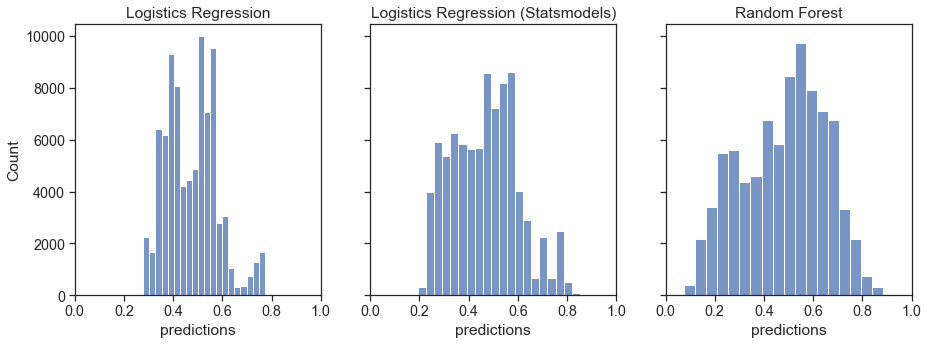

In [113]:
seaborn.set_theme(font_scale=1.3, style='ticks')
f, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

seaborn.histplot(y_pred_lr, ax=axes[0], stat='count', bins=20, label='asd')
axes[0].set_title("Logistics Regression")
axes[0].set_xlim(0, 1)
axes[0].set_xlabel('predictions');

seaborn.histplot(y_pred_sm, ax=axes[1], stat='count', bins=20)
axes[1].set_title("Logistics Regression (Statsmodels)")
axes[1].set_xlim(0, 1)
axes[1].set_xlabel('predictions');

seaborn.histplot(y_pred_rf, ax=axes[2], stat='count', bins=20)
axes[2].set_title("Random Forest")
axes[2].set_xlim(0, 1)
axes[2].set_xlabel('predictions');


A few things can be extracted from these diagnostic plots:

  1. The Random Forest classifier has the most difficulties detecting the positive signal
     in the test data. 
     Even though only a minority of its predictions are in the upper range of the probability
     distribution (as expected due to the heavily imbalanced test data), there is no
     clear separation between the two classes. 
     All in all the majority of the predictions are centered around 0.5, which suggests that
     the classifier is unsure in most cases
     
     
  2. The two logistics regressions look very similar. Recall that the only substantial difference between
     the two is how the categorical features are encoded. 
     There is a much clearer separation between a minority class in the upper range of the probability
     distribution and the *rest* (rest corresponding to the majority class of "no sale"). 
     However, the rest is not clearly separated into its own cluster towards the lower range of the
     probability distribution. Instead there are two peaks around 0.4 and 0.6.
     This indicates that the models are unsure as to what really makes a negative sample (no sale) and
     suggests that we will have a lot of false positives (low precision).

**Feature Importance**

There are many ways to obtain feature importances. One way that is model agnostic
is to compute the **permutation feature importances**.

Each feature is shuffled several times and the effect on the model metric are
averaged to produce the average impact the value of that feature has.

This is a great way to capture non-linear dependencies in a model agnostic way.


In [114]:
def plot_feature_importance(estimator, X, y,
                            label='Permutation Importances (test set)',
                            axes=None):

    result = permutation_importance(estimator, X, y,
                                    scoring='f1',
                                    n_repeats=10, random_state=42, n_jobs=-1)
    result['importances_mean']
    
    sorted_idx = result.importances_mean.argsort()
    axes.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx]
    )
    axes.set_title(label)

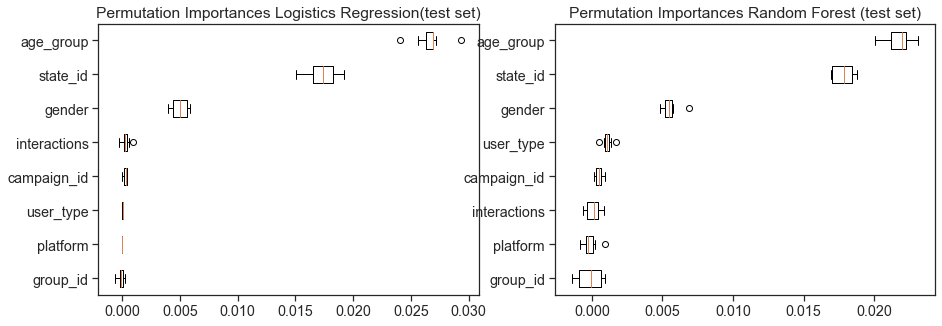

In [115]:
seaborn.set_theme(font_scale=1.3, style='ticks')
f, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_feature_importance(best_estimator_lr, X_test_processed, y_test,
                        label='Permutation Importances Logistics Regression(test set)',
                        axes=axes[0])

plot_feature_importance(rf_pipe, X_test_processed, y_test,
                        label='Permutation Importances Random Forest (test set)',
                        axes=axes[1])


For both models we see that the top 3 features that stand out in terms
of importance are `age_group`, `state_id` and `gender`.

These are incidently the features we had already identified from our preliminary
descriptive analysis.

**F1 Score**

The standard f1 score is computed assuming a classification threshold of
0.5

In [116]:
score_lr = f1_score(y_test['sale'], best_estimator_lr.predict(X_test_processed))
score_rf = f1_score(y_test['sale'], rf_pipe.predict(X_test_processed))
score_sm = f1_score(y_test['sale'], 1 * (y_pred_sm > 0.5))

In [117]:
f1_table=f"""

| model   	| F1 Score                                                  	|
|--------------	|----------------------------------------------------------	|
| Dummy classifier              	    | {dummy_clf_f1}                   	|
| Logistics Regression              	| {score_lr}                       	|
| Random Forest                     	| {score_rf}                       	|
| Logistics Regression (statsmodels)  	| {score_sm} 	                    |
"""

display(Markdown(f1_table))



| model   	| F1 Score                                                  	|
|--------------	|----------------------------------------------------------	|
| Dummy classifier              	    | 0.12117806498529071                   	|
| Logistics Regression              	| 0.16370220959017145                       	|
| Random Forest                     	| 0.15782001568029155                       	|
| Logistics Regression (statsmodels)  	| 0.17048010169160063 	                    |


Even though all baselines are doing better than the dummy classifier,
the improvement is not considerable.

Let's see how the f1 score depends on the classification threshold:

In [118]:
def compute_fscores(ytest, ypred):
    fscores_array = []
    max_f1 = -10
    max_th = -10

    for th in np.linspace(0, 1, 9):
        f1_at_th = f1_score(ytest, 1 * (ypred > th))
        
        if f1_at_th > max_f1:
            max_f1 = f1_at_th
            max_th = th
        
        fscores_array.append(f1_at_th)
    
    return (fscores_array, max_f1, max_th)

In [119]:

f1scores_lr, max_f1_lr, max_th_lr = compute_fscores(y_test['sale'], y_pred_lr)
f1scores_rf, max_f1_rf, max_th_rf = compute_fscores(y_test['sale'], y_pred_rf)
f1scores_sm, max_f1_sm, max_th_sm = compute_fscores(y_test['sale'], y_pred_sm)

max_idx = np.argmax([max_f1_lr, max_f1_rf, max_f1_sm])

max_f1 = np.array([max_f1_lr, max_f1_rf, max_f1_sm])[max_idx]
max_th = np.array([max_th_lr, max_th_rf, max_th_sm])[max_idx]

In [120]:
display(Markdown(f"**Maximum F score of {max_f1} is achieved at classification threshold {max_th}**"))


**Maximum F score of 0.17048010169160063 is achieved at classification threshold 0.5**

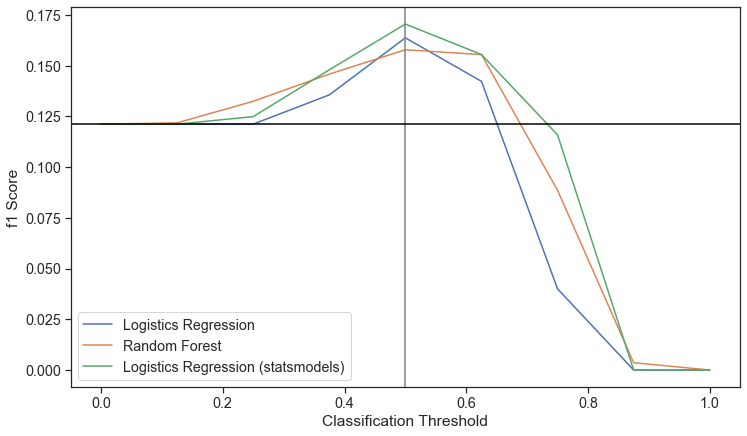

In [121]:
seaborn.set_theme(font_scale=1.3, style='ticks')
f, axes = plt.subplots(1, 1, figsize=(12, 7))


seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_lr, estimator=None, ax=axes, label='Logistics Regression');
seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_rf, estimator=None, ax=axes, label='Random Forest');
seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_sm, estimator=None, ax=axes,
                 label='Logistics Regression (statsmodels)');
plt.axvline(x=max_th, color='grey')
plt.axhline(y=dummy_clf_f1, color='black')


plt.xlabel('Classification Threshold');
plt.ylabel('f1 Score');


The solid horizontal black line indicates the f1 score expected by the dummy classifier,
while the vertical grey line is the threshold at which the maximum f1 score is achieved
by our baselines.

The bottom line here is that the baselines are definitely learning to distinguish
the positive signal of a sale and do offer improvement over an uninformed classifier,
however, there're still issues with the precision.

We will see these issues more concretely below


**ROC Curve**

The RoC curve offers as a good way to balance false positives and
true positives.

In [122]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)

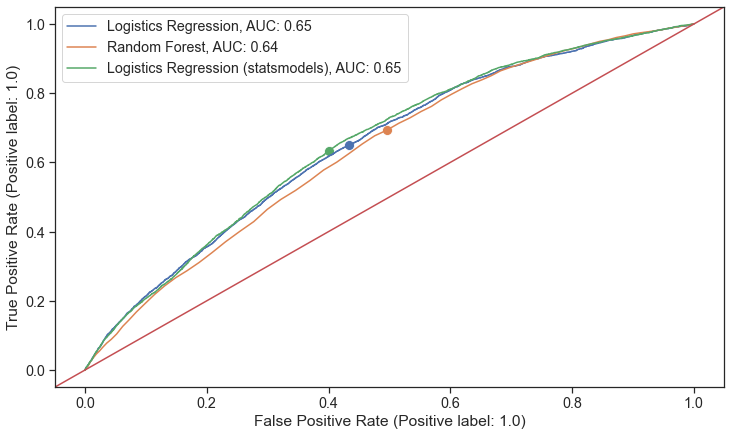

In [123]:
seaborn.set_theme(font_scale=1.3, style='ticks')

f, axes = plt.subplots(1, 1, figsize=(12, 7))

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes,
                 label=f'Logistics Regression, AUC: {auc_lr}');
seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes,
                 label=f'Random Forest, AUC: {auc_rf}');
seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');

idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[fpr_lr[idx_lr]], y=[tpr_lr[idx_lr]], ax=axes, s=100)
seaborn.scatterplot(x=[fpr_rf[idx_rf]], y=[tpr_rf[idx_rf]], ax=axes, s=100)
seaborn.scatterplot(x=[fpr_sm[idx_sm]], y=[tpr_sm[idx_sm]], ax=axes, s=100)

axes.plot([0, 1], [0, 1], transform=axes.transAxes)

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


The AUC scores a further indication that the improvement over the dummy classifier (red line)
are not considerable.

**Precision-Recall Curves**

Below we look at the corresponding tradeoffs between precision and recall, which ultimately
determine the f1 score we choose.

In [124]:
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test, y_pred_lr)
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
precisions_sm, recalls_sm, thresholds_sm = precision_recall_curve(y_test, y_pred_sm)

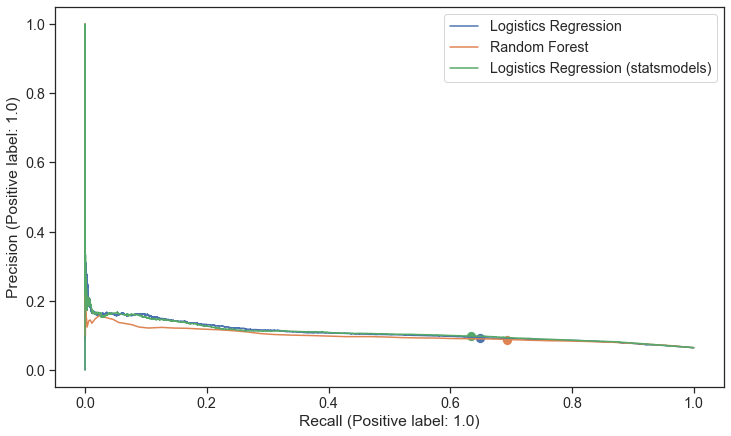

In [125]:
seaborn.set_theme(font_scale=1.3, style='ticks')

f, axes = plt.subplots(1, 1, figsize=(12, 7))

seaborn.lineplot(x=recalls_lr, y=precisions_lr,
                 estimator=None, ax=axes, label=f'Logistics Regression');
seaborn.lineplot(x=recalls_rf, y=precisions_rf,
                 estimator=None, ax=axes, label=f'Random Forest');
seaborn.lineplot(x=recalls_sm, y=precisions_sm,
                 estimator=None, ax=axes, label=f'Logistics Regression (statsmodels)');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[recalls_lr[idx_lr]], s=100,
                    y=[precisions_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[recalls_rf[idx_rf]], s=100,
                    y=[precisions_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[recalls_sm[idx_sm]], s=100,
                    y=[precisions_sm[idx_sm]], ax=axes)

plt.xlabel('Recall (Positive label: 1.0)');
plt.ylabel('Precision (Positive label: 1.0)');


The solid circles indicate the points in the curves that achieve the maximum f1 score 
of all three baseline models.

The optimal point on this curve corresponds to a relatively high recall, but low
precision.

We have already seen an indication for that from the distribution plots
of the predictions.
The models seem to have troubles determining what exactly consitutes a "no sale", while
being able to extract useful information on what constitues a sale.

We are of course interested in predicting sales, so high recall can be seen as beneficial, 
however, as already mentioned low precision runs the risk of approaching disinterested
customers and alienating them if pressing too aggresively. In a real-life campaign, there will
most certainly be post-processing checks (typically called collision management) that would
ensure the same customer is not approached too often.


## Challenger Model

To challenge our simple baselines, we will try two more advanced methods.

One is a gradient boosting method and the other a simple neural network.

We will implement Gradient Boosting with the `catboost` package.
The package offers a very flexible implementation that encodes
categorical variables automatically. 
It uses different encoding schemes depending on the cardinality
of each categorical variable and in practive works well out of the box.

For this reason we'll use the raw categorical features in `catboost`,
but the corresponding code that uses our custom taget coding scheme
is still available as an alternative.

### Gradient Boosting

In [126]:
from catboost import CatBoostClassifier, Pool, cv


cat_features = [0, 1, 2, 3, 4, 5, 6]

train_dataset = Pool(data=X_train.iloc[sample_indeces],
                     label=y_train.iloc[sample_indeces]['sale'],
                     cat_features=cat_features)

test_dataset = Pool(data=X_test, label=y_test['sale'],
                    cat_features=cat_features)

In [127]:
clf = CatBoostClassifier(depth=5,
                         iterations=1000,
                         l2_leaf_reg=1,
                         loss_function="Logloss",
                         eval_metric="F1",
                         logging_level='Silent',
                         boost_from_average=True,
                         langevin=True)

In [128]:
clf.fit(train_dataset)

In [129]:
pos_label_index_cb = np.where(clf.classes_ == 1)[0]
y_pred_cb = clf.predict_proba(test_dataset)[:,pos_label_index_cb].squeeze()

In [130]:
score_cb = f1_score(test_dataset.get_label(),
                    clf.predict(test_dataset))

In [131]:
score_cb

0.16316135065761983

In [132]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_cb)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)
auc_cb = np.round(roc_auc_score(y_test, y_pred_cb), 2)

Catboost offers an easy way to extract feature importances. 
The default method, *PredictionValueChange* is similar to permutation
feature importance, so we it.

In [133]:
clf.get_feature_importance(data=test_dataset, type='PredictionValuesChange',
                           prettified=True)

Feature Id  Importances
0      state_id    33.188040
1     age_group    27.820842
2        gender    11.525431
3      group_id     9.650438
4     user_type     6.272892
5   campaign_id     4.912181
6  interactions     4.517615
7      platform     2.112560

Unsurprisingly, `state_id`, `age_group` and `gender` are again on the top.

### Neural Network

Nothing fancy, just a simple fully connected neural network.

In [134]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

@tf.autograph.experimental.do_not_convert
def f1_nn(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():

    nn = tf.keras.Sequential([    
        tf.keras.layers.Dense(128, input_dim=X_train_processed_resampled.shape[1],
                              activation='relu'),
        tf.keras.layers.Dense(32, input_dim=128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_nn])
    
    return nn


In [135]:
clf_nn = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, use_multiprocessing=True)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [136]:
clf_nn.fit(X_train_processed_resampled, y_train_processed_resampled['sale'])

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.6813 - f1_nn: 0.4968
Epoch 2/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6638 - f1_nn: 0.5851
Epoch 3/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6614 - f1_nn: 0.6067
Epoch 4/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6612 - f1_nn: 0.6094
Epoch 5/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6603 - f1_nn: 0.6183
Epoch 6/20
1375/1375 [==============================] - 1s 996us/step - loss: 0.6594 - f1_nn: 0.6181
Epoch 7/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6598 - f1_nn: 0.6223
Epoch 8/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6591 - f1_nn: 0.6322
Epoch 9/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6587 - f1_nn: 0.6314
Epoch 10/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6586 - f1_nn: 0.6319
Epoch 1

In [137]:
y_pred_nn = clf_nn.predict(X_test_processed)

In [138]:
score_nn = f1_score(y_test['sale'], y_pred_nn)

In [139]:
y_pred_nn_raw = clf_nn.predict_proba(X_test_processed)[:, 1]

Feature importances for the neural network can be easily obtained
with the `shap` method.

Importantly, if one-hot coding had been chosen `shap` is not reliable, 
hence we'll focus only on the case with target coding.

In [140]:
import shap

ke = shap.KernelExplainer(clf_nn.model,
                          shap.sample(X_train_processed_resampled.values, 100))

shap_values = ke.shap_values(shap.sample(X_test_processed, 100),
                             check_additivity=False)

  0%|          | 0/100 [00:00<?, ?it/s]

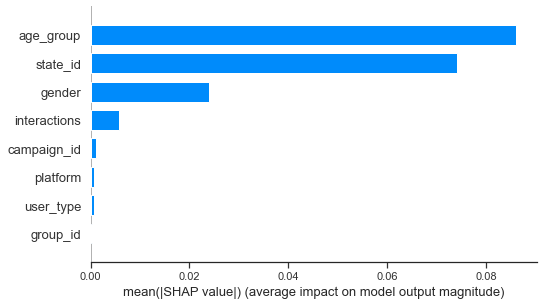

In [141]:
shap.initjs()
shap.summary_plot(
    shap_values[0], 
    feature_names=X_test_processed.columns,
    max_display=50,
    plot_type='bar')

## Comparison Baseline Models <-> Challengers

**Prediction distributions**

We'll add the distribution of the predictions on the test dataset from the two
challenger models to the ones from the baselines

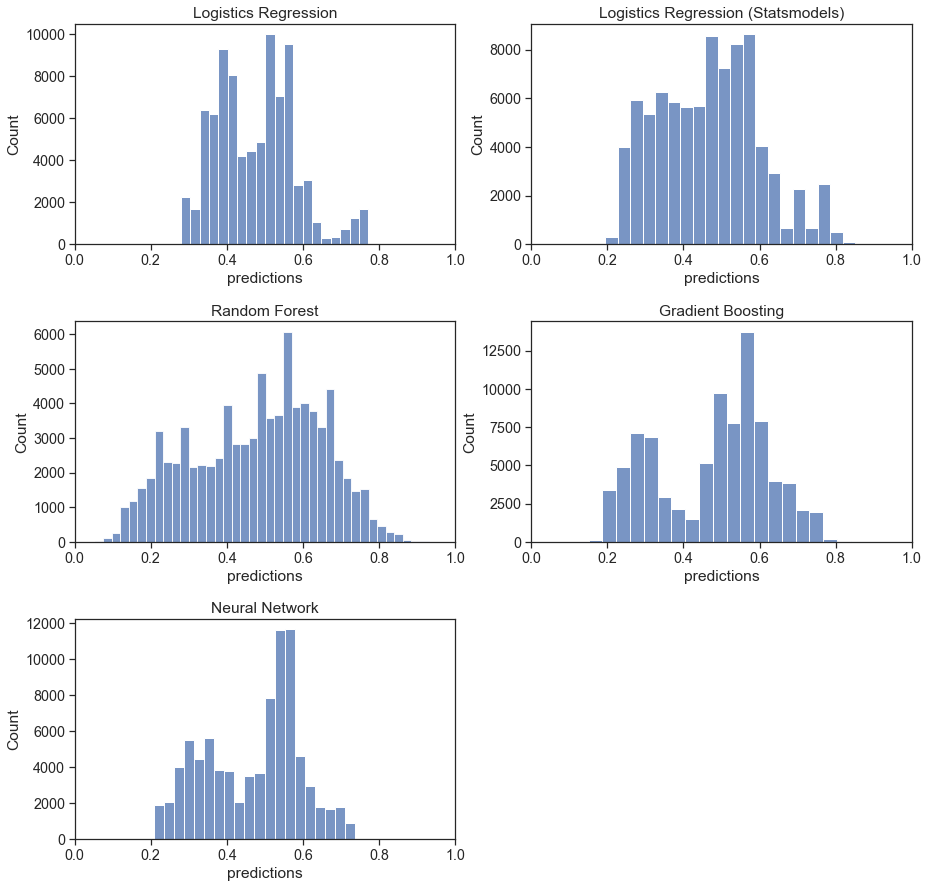

In [142]:
seaborn.set_theme(font_scale=1.3, style='ticks')
f, axes = plt.subplots(3, 2, figsize=(15, 15))

seaborn.histplot(y_pred_lr, ax=axes[0][0], stat='count', bins=20, label='asd')
axes[0][0].set_title("Logistics Regression")
axes[0][0].set_xlim(0, 1)
axes[0][0].set_xlabel('predictions');

seaborn.histplot(y_pred_sm, ax=axes[0][1], stat='count', bins=20)
axes[0][1].set_title("Logistics Regression (Statsmodels)")
axes[0][1].set_xlim(0, 1)
axes[0][1].set_xlabel('predictions');

seaborn.histplot(y_pred_rf, ax=axes[1][0], stat='count', bins=40)
axes[1][0].set_title("Random Forest")
axes[1][0].set_xlim(0, 1)
axes[1][0].set_xlabel('predictions');

seaborn.histplot(y_pred_cb, ax=axes[1][1], stat='count', bins=20)
axes[1][1].set_title("Gradient Boosting")
axes[1][1].set_xlim(0, 1)
axes[1][1].set_xlabel('predictions');

seaborn.histplot(y_pred_nn_raw, ax=axes[2][0], stat='count', bins=20)
axes[2][0].set_title("Neural Network")
axes[2][0].set_xlim(0, 1)
axes[2][0].set_xlabel('predictions');

axes[2][1].axis('off')

plt.subplots_adjust(hspace=0.35)

As indicated by the two more pronounced peaks in the histograms, the challenger models appear to be slightly more discerning about the majority class, while still identifying a small minority.
However, the second higher peak suggests that we still have a lot of "no sales" cases, which get disproportionately classified as "sales".

Therefore the challenger models, as well, have difficulty in identifying "no sales", albeit to a lesser extent.

**F1 scores**

In [143]:
f1_table=f"""

| model   	| F1 Score                                                  	|
|--------------	|----------------------------------------------------------	|
| Dummy classifier              	    | {dummy_clf_f1}                   	|
| Logistics Regression              	| {score_lr}                       	|
| Random Forest                     	| {score_rf}                       	|
| Logistics Regression (statsmodels)  	| {score_sm} 	                    |
| Gradient Boosting                  	| {score_cb}               	        |
| Neural Network                    	| {score_nn}                        |
"""

display(Markdown(f1_table))



| model   	| F1 Score                                                  	|
|--------------	|----------------------------------------------------------	|
| Dummy classifier              	    | 0.12117806498529071                   	|
| Logistics Regression              	| 0.16370220959017145                       	|
| Random Forest                     	| 0.15782001568029155                       	|
| Logistics Regression (statsmodels)  	| 0.17048010169160063 	                    |
| Gradient Boosting                  	| 0.16316135065761983               	        |
| Neural Network                    	| 0.1584650561686052                        |


The F-score further confirm that the two challenger models do not offer
noticeable improvement over the baselines.

Let's see how the f1 score depends on the classification threshold:

In [144]:
f1scores_cb, max_f1_cb, max_th_cb = compute_fscores(y_test['sale'], y_pred_cb)
f1scores_nn, max_f1_nn, max_th_nn = compute_fscores(y_test['sale'], y_pred_nn_raw)

In [145]:
max_idx = np.argmax([max_f1, max_f1_cb, max_f1_nn])

max_f1 = np.array([max_f1, max_f1_cb, max_f1_nn])[max_idx]
max_th = np.array([max_th, max_th_cb, max_th_nn])[max_idx]

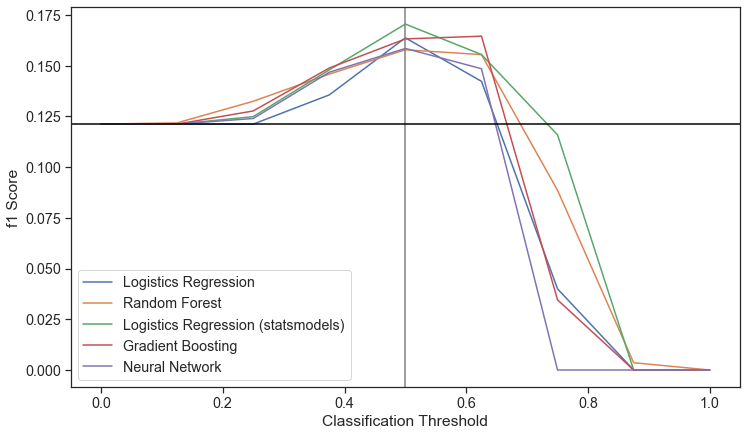

In [146]:
seaborn.set_theme(font_scale=1.3, style='ticks')
f, axes = plt.subplots(1, 1, figsize=(12, 7))


seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_lr, estimator=None, ax=axes, label='Logistics Regression');

seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_rf, estimator=None, ax=axes, label='Random Forest');

seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_sm, estimator=None, ax=axes,
                 label='Logistics Regression (statsmodels)');

seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_cb, estimator=None, ax=axes,
                 label='Gradient Boosting');

seaborn.lineplot(x=np.linspace(0, 1, 9),
                 y=f1scores_nn, estimator=None, ax=axes,
                 label='Neural Network');

plt.axvline(x=max_th, color='grey')
plt.axhline(y=dummy_clf_f1, color='black')


plt.xlabel('Classification Threshold');
plt.ylabel('f1 Score');

Again, the logistics regression appears to be outperfoming all the others

**ROC Curve**

In [147]:
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_cb)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_nn_raw)

auc_cb = np.round(roc_auc_score(y_test, y_pred_cb), 2)
auc_nn = np.round(roc_auc_score(y_test, y_pred_nn_raw), 2)

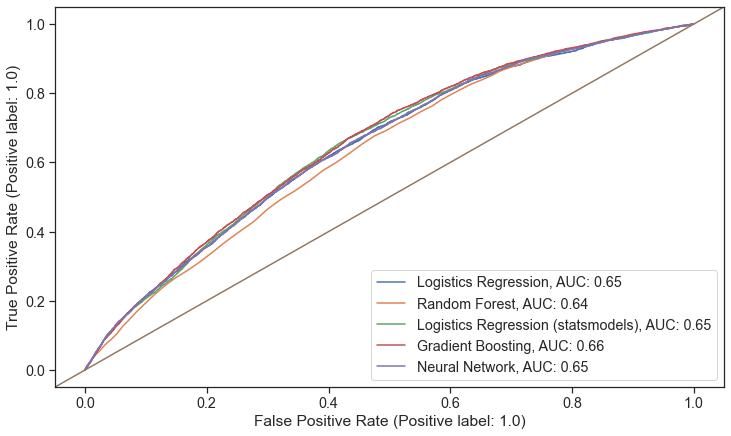

In [148]:
seaborn.set_theme(font_scale=1.3, style='ticks')

f, axes = plt.subplots(1, 1, figsize=(12, 7))

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes,
                 label=f'Logistics Regression, AUC: {auc_lr}');

seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes,
                 label=f'Random Forest, AUC: {auc_rf}');

seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');

seaborn.lineplot(x=fpr_cb, y=tpr_cb, estimator=None, ax=axes,
                 label=f'Gradient Boosting, AUC: {auc_cb}');

seaborn.lineplot(x=fpr_nn, y=tpr_nn, estimator=None, ax=axes,
                 label=f'Neural Network, AUC: {auc_nn}');

idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()
idx_cb = np.abs(thresholds_cb-max_th).argmin()
idx_nn = np.abs(thresholds_nn-max_th).argmin()

axes.plot([0, 1], [0, 1], transform=axes.transAxes)

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


**Precision-Recall Curves**

In [149]:
precisions_cb, recalls_cb, thresholds_cb = precision_recall_curve(y_test,
                                                                  y_pred_cb)
precisions_nn, recalls_nn, thresholds_nn = precision_recall_curve(y_test,
                                                                  y_pred_nn_raw)


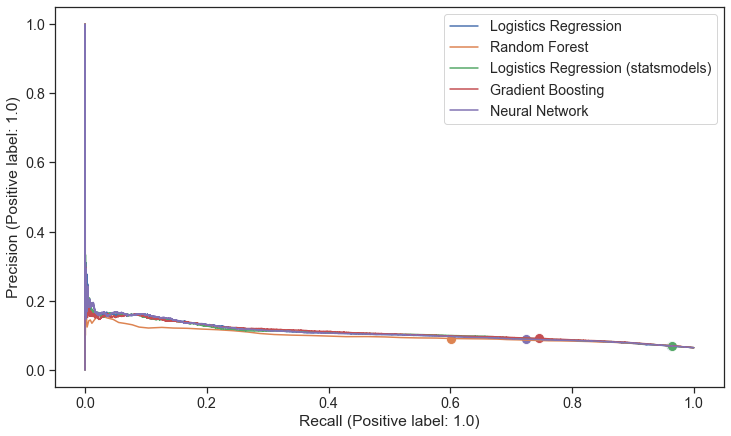

In [150]:
seaborn.set_theme(font_scale=1.3, style='ticks')

f, axes = plt.subplots(1, 1, figsize=(12, 7))

seaborn.lineplot(x=recalls_lr, y=precisions_lr,
                 estimator=None, ax=axes, label=f'Logistics Regression');

seaborn.lineplot(x=recalls_rf, y=precisions_rf,
                 estimator=None, ax=axes, label=f'Random Forest');

seaborn.lineplot(x=recalls_sm, y=precisions_sm,
                 estimator=None, ax=axes, label=f'Logistics Regression (statsmodels)');

seaborn.lineplot(x=recalls_cb, y=precisions_cb,
                 estimator=None, ax=axes, label=f'Gradient Boosting');

seaborn.lineplot(x=recalls_nn, y=precisions_nn,
                 estimator=None, ax=axes, label=f'Neural Network');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()
idx_cb = np.abs(thresholds_cb-max_th).argmin()
idx_nn = np.abs(thresholds_nn-max_th).argmin()


seaborn.scatterplot(x=[recalls_lr[idx_lr]], s=100,
                    y=[precisions_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[recalls_rf[idx_rf]], s=100,
                    y=[precisions_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[recalls_sm[idx_sm]], s=100,
                    y=[precisions_sm[idx_sm]], ax=axes)
seaborn.scatterplot(x=[recalls_cb[idx_cb]], s=100,
                    y=[precisions_cb[idx_cb]], ax=axes)
seaborn.scatterplot(x=[recalls_nn[idx_nn]], s=100,
                    y=[precisions_nn[idx_nn]], ax=axes)

plt.xlabel('Recall (Positive label: 1.0)');
plt.ylabel('Precision (Positive label: 1.0)');

Again the optimal point on this curve corresponds to a relatively high recall, but low
precision.


All models seem to have troubles determining what exactly consitutes a "no sale", while
being able to extract useful information on what constitues a sale.

# Summary

Below are some summary points to wrap things up.

   1.  Predicting the minority class is a hard problem in general, especially
       in the presence of high target imbalance and high cardinality categorical 
       features.
       
       
   2.  The presence of mostly categorical features further complicates the issue.
       Experimenting with different encoding schemes is a major part of data preparation.
   
   
   3.  All models tend to improve recall at the expense of precision, which
       might be acceptable from a business perspective.
       
   
   4.  All models (baseline+challenger) have very similar performance in terms 
       of the F score. It's low, but still better than an uninformed model.
       
       
   5.  Due to the low performance out of the box, a more efficient approach for improvement
       would be at the data processing stage rather than hyperparameter tuning.
       
       
   6.  Three features appear to be most informative on predicting a sale across all models -
       `gender`, `age_group` and `state_id`.
   
       
   7.  Extracting information about the majority class (no sale) appears to be a challenge.
       This suggests that the influential features above contain sufficient information
       about "sale" events, but ambiguous about "no sale".
       
       This is akin to a hypothetical situation where a feature, such as `first_car=1`,
       is highly predictive of a customer being interested in car insurance (because it's
       mandated by law), yet `first_car=0` alone tells us litte about interest in car insurance per se.
       
         
   8.  Try separate models for different slices of the three most informative features.
       Sometimes customer behaviour is distinct enough across important dimensions and it's
       better ot model it separately.
       
       
   9.  Any model that ends up being selected should be calibrated as a last step.
       Having calibrated predictions is not that important if customers are scored
       accoring to their probability of buying an insurance, but is crucial if
       expected returns are to be factored into the business decision.